In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from PIL import Image
import os
import torch.nn.functional as F

In [ ]:
class block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        x = self.softmax(x)

        return x

    def make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels * block.expansion))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * block.expansion

        for i in range(1, num_residual_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


In [ ]:
# Load the augmented data into a dataset
data_transforms_res = transforms.Compose([
    transforms.Resize(256), # Resize to a larger size to ensure all images are covered
    transforms.CenterCrop(224), # Crop the center of the image to 224x224
    transforms.ToTensor(),
])
combined_data_dir = '/content/drive/MyDrive/MP_Dataset/autism/combined_dataset'
combined_dataset = ImageFolder(combined_data_dir, transform=data_transforms_res)

# Define the lengths of the training and validation sets
train_size = len(combined_dataset)
validation_size = int(train_size * 0.2) # 20% of the data for validation
train_size = train_size - validation_size # Adjust the training size

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(combined_dataset, [train_size, validation_size])

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=2)

# Update the dataset_sizes dictionary to include the validation set
dataset_sizes = {
    'train': train_size,
    'validation': validation_size
}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import os

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define paths
model_save_path = '/content/drive/MyDrive/MP_Dataset/SpectrumSense/Model_checkpoints/ResNET34/ResNET-34_100epochs.pth'
checkpoint_exists = os.path.isfile(model_save_path)

# Initialize the model
model = ResNet(block, [3, 4, 6, 3], image_channels=3, num_classes=len(combined_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Adjust parameters as needed

# Load the checkpoint if it exists
if checkpoint_exists:
    checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    # Move the model to the GPU
    model = model.to(device)
    # Move the optimizer's state dict to the GPU
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']
else:
    # If the checkpoint does not exist, initialize the last epoch and loss
    last_epoch = 0
    last_loss = 0.0

# Move the model to the appropriate device
model = model.to(device)

num_epochs = 100
early_stop_epochs = 15  # Number of epochs to wait for early stopping
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(last_epoch + 1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    # Update the learning rate
    scheduler.step()

    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Use the appropriate DataLoader based on the phase
        if phase == 'train':
            dataloader = train_dataloader
        else:
            dataloader = validation_dataloader

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Check for early stopping based on validation loss
        if phase == 'validation':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= early_stop_epochs:
                print('Early stopping triggered! No improvement in validation loss for {} epochs.'.format(
                    epochs_without_improvement))
                break  # Exit training loop


    # Save the model state after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': epoch_acc,
    }, model_save_path)

    if epochs_without_improvement >= early_stop_epochs:
      break  # Exit epoch loop if early stopping triggered


print('Training complete')


Epoch 12/100
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.6245 Acc: 0.6636
validation Loss: 0.5956 Acc: 0.6983
Epoch 13/100
----------
train Loss: 0.6218 Acc: 0.6645
validation Loss: 0.6047 Acc: 0.6949
Epoch 14/100
----------
train Loss: 0.6207 Acc: 0.6677
validation Loss: 0.5948 Acc: 0.7017
Epoch 15/100
----------
train Loss: 0.6172 Acc: 0.6681
validation Loss: 0.6039 Acc: 0.6889
Epoch 16/100
----------
train Loss: 0.6181 Acc: 0.6642
validation Loss: 0.6044 Acc: 0.6803
Epoch 17/100
----------
train Loss: 0.6153 Acc: 0.6713
validation Loss: 0.5958 Acc: 0.6991
Epoch 18/100
----------
train Loss: 0.6074 Acc: 0.6830
validation Loss: 0.5931 Acc: 0.6932
Epoch 19/100
----------
train Loss: 0.6053 Acc: 0.6897
validation Loss: 0.5911 Acc: 0.7034
Epoch 20/100
----------
train Loss: 0.6010 Acc: 0.6944
validation Loss: 0.5898 Acc: 0.7060
Epoch 21/100
----------
train Loss: 0.6027 Acc: 0.6939
validation Loss: 0.5880 Acc: 0.7009
Epoch 22/100
----------
train Loss: 0.6020 Acc: 0.6927
validation Loss: 0.5872 Acc: 0.7060
Epoch 23/100
----------

Precision: 0.9558823529411765
Recall: 0.65
F1-score: 0.7738095238095238
Accuracy: 0.81
Confusion Matrix:
Specificity: 0.97
[[97  3]
 [35 65]]


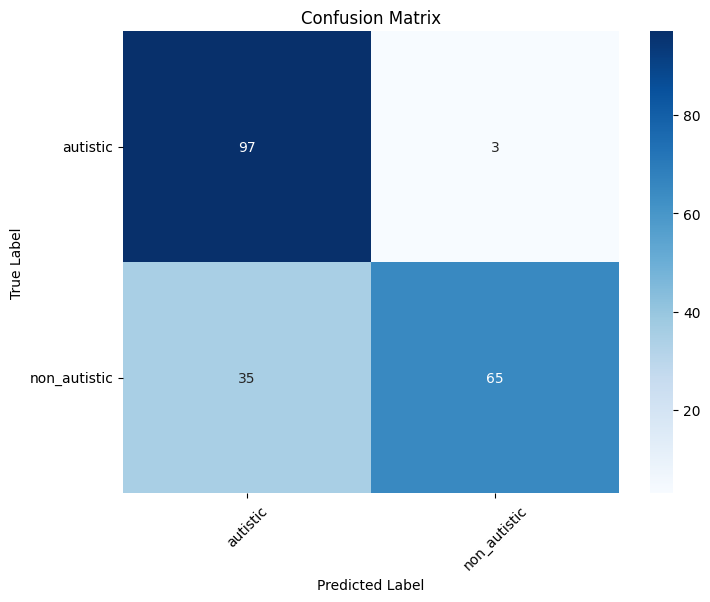

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transforms for evaluation
data_transforms_res = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.CenterCrop(224),      # Center crop
    transforms.ToTensor(),           # Convert to tensor
])

# Load the dataset for evaluation
eval_dataset = ImageFolder('/content/drive/MyDrive/MP_Dataset/autism/test', transform=data_transforms_res)

# Create DataLoader for evaluation
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

# Load the MobileNetV3 model
model = ResNet(block, [3, 4, 6, 3], image_channels=3, num_classes=len(eval_dataset.classes))
checkpoint = torch.load('/content/drive/MyDrive/MP_Dataset/SpectrumSense/Model_checkpoints/ResNET34/ResNET-34_100epochs.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize lists to store predictions and ground truth labels
all_preds = []
all_labels = []

# Iterate over the evaluation dataset
for inputs, labels in eval_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print("Specificity:", specificity)
print(conf_matrix)
classes = eval_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/MP_Dataset/SpectrumSense/Model_checkpoints/ResNET34/ResNET-34_100epochs.pth'

# Path to the test image
test_image_path = '/content/drive/MyDrive/MP_Dataset/autism/test/non_autistic/050.jpg'


#ASK ME BEFORE RUNNING THIS CODE
data_transforms_test = transforms.Compose([
    transforms.Resize(256), # Resize to a larger size to ensure all images are covered
    transforms.CenterCrop(224), # Crop the center of the image to 224x224
    transforms.ToTensor(),
])


model = ResNet(block,[3, 4, 6, 3], image_channels=3, num_classes=len(combined_dataset.classes))
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() # Set the model to evaluation mode
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Load and transform the test image
image = Image.open(test_image_path)
image = data_transforms_test(image).unsqueeze(0)

image = image.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)
    _, preds = torch.max(probabilities, 1)

class_names = ['Not Autistic', 'Autistic']

# Predicted class name
predicted_class = class_names[preds.item()]

# Print the probabilities of confidence rate for each class
print(f'Predicted class: {predicted_class}')
print(f'Probabilities: {probabilities.tolist()}')

Predicted class: Autistic
Probabilities: [[0.31407424807548523, 0.6859257817268372]]
